# Creating the IOOS Asset Inventory

This notebook walks through the process for creating the asset inventory from the spreadsheets collected from the Regional Associations.

First we need to import some libraries and enable KML support.

In [1]:
import fiona
import geopandas
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

Now we identify the directory where the excel spreadsheets are found. This should be edited to correspond with the appropriate year and file type to be processed.

In [2]:
year = '2022'
dir = year+'/data/processed/'
all_files = os.listdir(dir)

regex = re.compile(r'~.*')

files = [i for i in all_files if not regex.match(i)]

print('Found %i Excel workbooks' % len(files))

Found 10 Excel workbooks


Now start building the pandas DataFrame to capture the information in the spreadsheets. We do some minor cleaning here, including:
 * dropping empty rows
 * removing special characters
 * adding RA column if spreadsheet doesn't have it

In [3]:
df_raw = pd.DataFrame(
    columns=['RA', 'Station ID', 'WMO ID or NWS/CMAN ID', 'Station Long Name',
       'Station Description', 'Latitude (dec deg)', 'Longitude (dec deg)',
       'Platform Type', 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)',
       'Currently Operational? (Y, N, O, U)', 'Platform Funder/Sponsor',
       'RA Funding Involvement (Yf, Yp, N)', 'Platform Operator/Owner',
       'Operator Sector', 'Platform Maintainer', 'Data Manager',
       'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].',
       'Additional notes', 'file']
)
for file in files:
    fname = dir + file

    print('Reading %s' % file)
    df = pd.read_excel(fname, header=0)

    # Drop empty rows
    df.dropna(axis='index', how='all', inplace=True)
    # Removing special chars
    df.replace('\xa0', '', regex=True, inplace=True)
    df.replace('\n','', regex=True, inplace=True) # remove carriage returns

    # create RA column if missing
    if 'RA' not in df.columns:
        df['RA'] = file.split(".")[0]

    # add the file name for use later
    df['file'] = file

    # concatenate data frames into one mongo DF.
    df_raw = pd.concat([df_raw, df], ignore_index=True)

    # print some information out
    print('Ingested %s with %i columns' % (file, len(df.columns)))

print('Initial row count: %i' % df_raw.shape[0])

Reading AOOS.xlsx
Ingested AOOS.xlsx with 19 columns
Reading CARICOOS.xlsx
Ingested CARICOOS.xlsx with 19 columns
Reading CENCOOS.xlsx
Ingested CENCOOS.xlsx with 19 columns
Reading GCOOS.xlsx
Ingested GCOOS.xlsx with 19 columns
Reading GLOS.xlsx
Ingested GLOS.xlsx with 19 columns
Reading NANOOS.xlsx
Ingested NANOOS.xlsx with 19 columns
Reading NERACOOS.xlsx
Ingested NERACOOS.xlsx with 19 columns
Reading PACIOOS.xlsx
Ingested PACIOOS.xlsx with 19 columns
Reading SCCOOS.xlsx
Ingested SCCOOS.xlsx with 19 columns
Reading SECOORA.xlsx
Ingested SECOORA.xlsx with 19 columns
Initial row count: 714


Now we need to do a little cleaning to remove platform types that shouldn't be part of the inventory. So, we create a copy of the dataFrame for processing and remove the rows that have platforms of `surface_current_radar` and `glider`.

In [4]:
#df_raw.loc[df_raw['RA'] == 'PacIOOS']

In [5]:
df_all = df_raw.copy()

df_all['RA'] = df_all['RA'].astype(str).str.strip()

print('Removing platform type = \'surface_current_radar\' | \'glider\'.')
df_all.drop(
    df_all.loc[
        (df_all['Platform Type'] == 'surface_current_radar') |
        (df_all['Platform Type'] == 'glider')
    ].index,
    inplace=True)
print('row count:', df_all.shape[0])

Removing platform type = 'surface_current_radar' | 'glider'.
row count: 714


Convert lat/lon to floating points.

In [6]:
#df_all.drop(
#    df_all.loc[df_all['Latitude (dec deg)'] == '(Required) '].index,
#    inplace=True)

In [7]:
#df_all.loc[df_all['Latitude (dec deg)'] == '35 15.555', ['file']]

In [8]:
df_all[['Latitude (dec deg)', 'Longitude (dec deg)']] = df_all[['Latitude (dec deg)', 'Longitude (dec deg)']].astype(float)

Find all bad coordinates and tell me which file they belong to and what the coordinates are.

In [9]:
df_all.loc[(df_all['Longitude (dec deg)']<-180) | (df_all['Longitude (dec deg)'] > 180) | (df_all['Latitude (dec deg)'] > 90) | (df_all['Latitude (dec deg)'] < -90), ['Latitude (dec deg)','Longitude (dec deg)','file']]

,Latitude (dec deg),Longitude (dec deg),file


In [10]:
df_all['RA Funding Involvement (Yf, Yp, N)'].unique()

array(['Yp', 'N', 'Yf', 'Y', nan], dtype=object)

In [11]:
df_all['Currently Operational? (Y, N, O, U)'].unique()

array(['Y', 'N', 'Y, O', 'O', 'U'], dtype=object)

In [12]:
df_all.loc[df_all['RA Funding Involvement (Yf, Yp, N)'].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,file,Dataset (ERDDAP) ID
179,CENCOOS,Morro Back Bay,NaN,Morro Back Bay BS1,Morro Back Bay BS1,35.33382,-120.84725,fixed pier,2018-09-20 00:00:00,Y,Cal Poly/CeNCOOS,NaN,Cal Poly,Academic,Cal Poly,Cal Poly,"sea_water_temperature(1m), sea_water_pressure(...",NaN,CENCOOS.xlsx,NaN
699,SECOORA,MSNB_N,MBNN7,Masonboro Island North,"Custom instrumment tower, 10' in height.",34.17120,-77.82340,fixed,2021-01-14 00:00:00,Y,UNCW/NSF,NaN,UNCW,Academic,UNCW,UNCW,"air_pressure, air_temperature, relative_humidi...",NaN,SECOORA.xlsx,NaN
700,SECOORA,MSNB_S,MBIN7,Masonboro Island South,"Custom instrumment tower, 10' in height.",34.09060,-77.86790,fixed,2020-12-17 00:00:00,Y,UNCW/NSF,NaN,UNCW,Academic,UNCW,UNCW,"air_pressure, air_temperature, relative_humidi...",NaN,SECOORA.xlsx,NaN


Saving dates as strings

In [13]:
df_all['Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)'] = \
    df_all['Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)'].astype(str)

Rename the columns for easier referencing later.

In [14]:
df_all.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

Make a simple plot of station locations

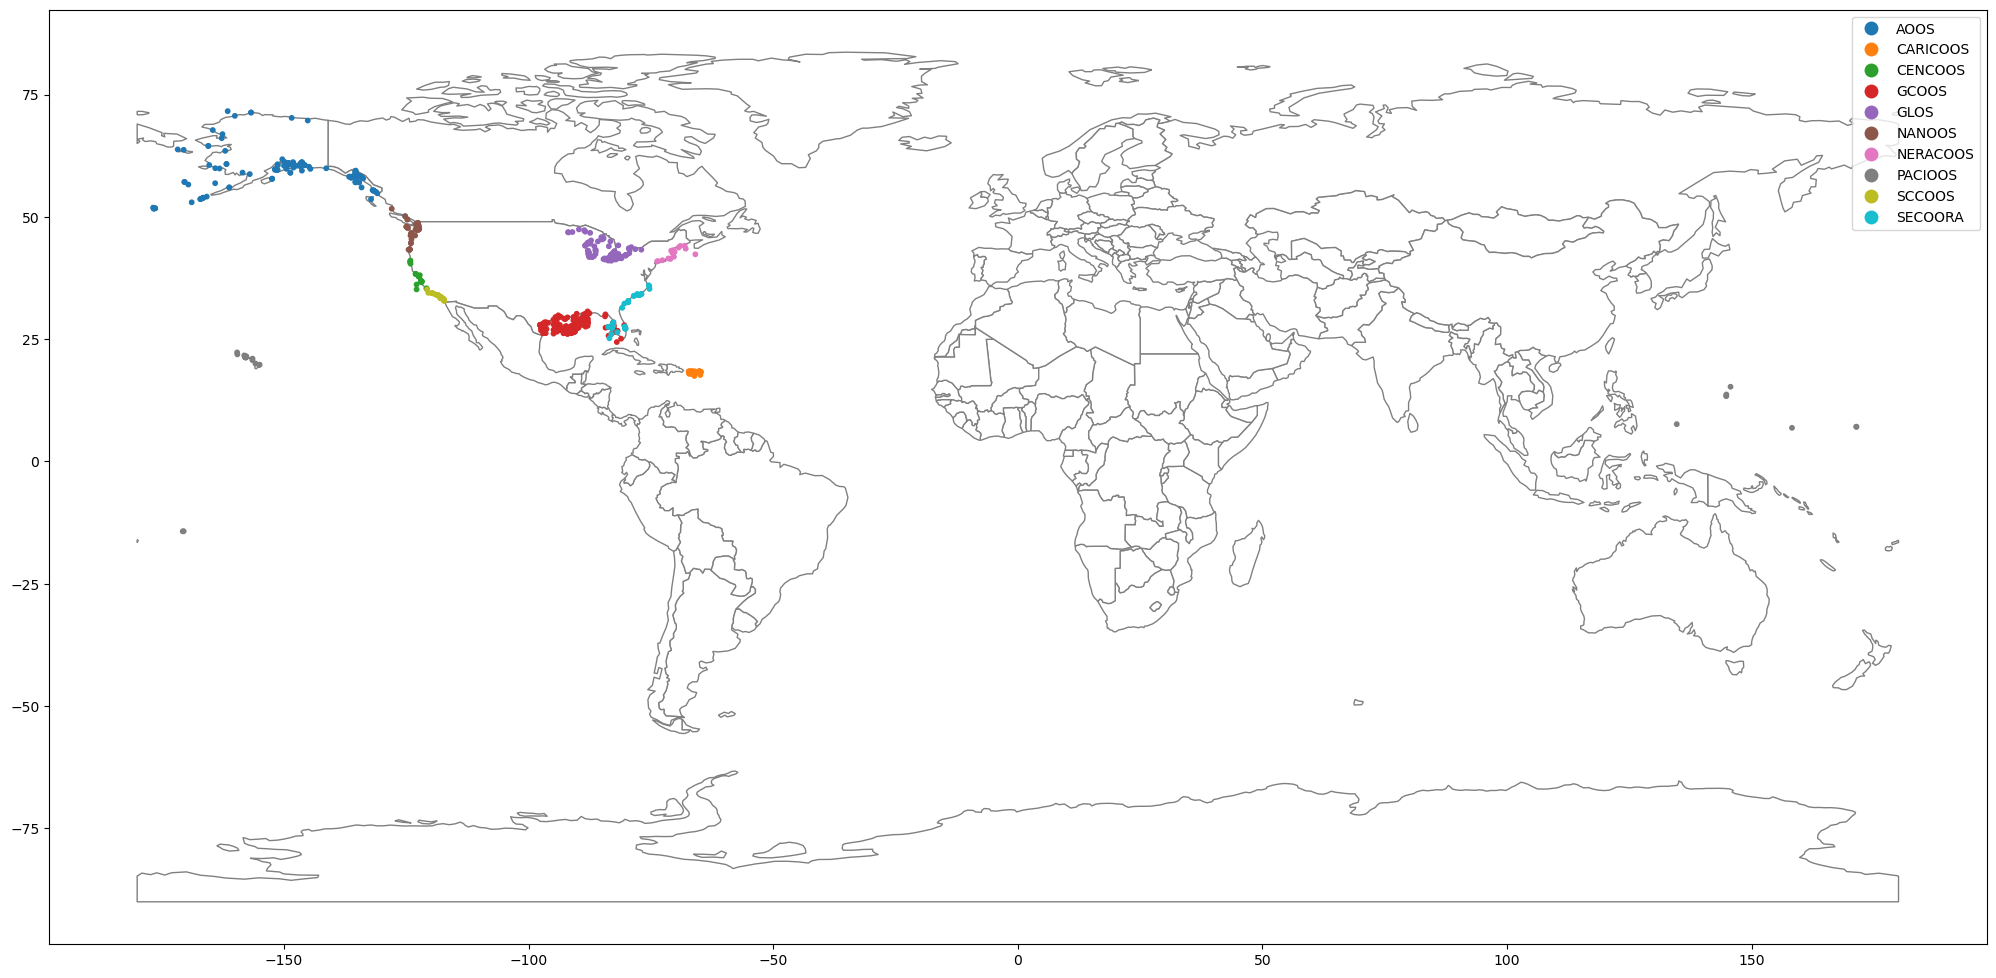

In [15]:
gdf = geopandas.GeoDataFrame(
    df_all, geometry=geopandas.points_from_xy(df_all['Longitude'], df_all['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot(ax=ax, 
         column='RA', 
         categorical=True, 
         markersize=10, 
         legend=True,
         k=11,
        )

plt.show()

Create a final DataFrame for processed file

In [16]:
df_final = pd.DataFrame(columns=
                        ['RA','Latitude','Longitude','Platform','Operational',
                         'RA_Funded','Water_temp','Salinity','Wtr_press',
                         'Dew_pt','Rel_hum','Air_temp','Winds','Air_press',
                         'Precip','Solar_radn','Visibility','Water_level','Waves',
                         'Currents','Turbidity','DO','pCO2_water','pCO2_air','TCO2',
                         'pH','OmgArag_st','Chl','Nitrate','CDOM','Alkalinity','Acoustics','file'])

df_final['RA'] = df_all['RA']
df_final['station_long_name'] = df_all['Station Long Name']
df_final['Latitude'] = df_all['Latitude']
df_final['Longitude'] = df_all['Longitude']
df_final['Platform'] = df_all['Platform Type']
df_final['Operational'] = df_all['Currently Operational? (Y, N, O, U)']
df_final['station_deployment'] = df_all['Station Deployment']
df_final['RA_Funded'] = df_all['RA Funding Involvement (Yf, Yp, N)']
df_final['Raw_Vars'] = df_all['Variable Names']
df_final['file'] = df_all['file']

Map provided variable text to standard vars and platforms to consistent platform categories

In [17]:
import utils.mapping

df_final = utils.mapping.variables(df_final, df_all)
df_final = utils.mapping.platforms(df_final)

Reorganize the DataFrame

In [18]:
cols = ['RA', 'Latitude', 'Longitude', 'station_long_name', 'Platform', 'Operational', 'station_deployment', 
        'RA_Funded', 'Water_temp', 'Salinity', 'Wtr_press', 'Dew_pt', 'Rel_hum', 'Air_temp',
        'Winds', 'Air_press', 'Precip', 'Solar_radn', 'Visibility',
        'Water_level', 'Waves', 'Currents', 'Turbidity', 'DO', 'pCO2_water',
        'pCO2_air', 'TCO2', 'pH', 'OmgArag_st', 'Chl', 'Nitrate', 'CDOM',
        'Alkalinity', 'Acoustics', 'Raw_Vars','file']
df_final = df_final[cols]

Create a geopandas DataFrame.

In [19]:
gdf_final = geopandas.GeoDataFrame(
    df_final, geometry=geopandas.points_from_xy(df_final['Longitude'], df_final['Latitude']))

Write data files.

In [ ]:
print('Saving inventory files...')
# csv
df_raw.to_csv(year+'/combined_raw_inventory.csv', index=False)
df_final.drop(labels='geometry', axis='columns', inplace=True)
df_final.to_csv(year+'/processed_inventory.csv', index=False)

# geojson
gdf.to_file(year+'/combined_raw_inventory.geojson', driver='GeoJSON')
gdf_final.to_file(year+'/processed_inventory.geojson', driver='GeoJSON')

# kml
gdf.to_file(year+'/combined_raw_inventory.kml', driver='LIBKML')
gdf_final.to_file(year+'/processed_inventory.kml', driver='LIBKML')

Saving inventory files...


In [ ]:
gdf_final = gdf_final.set_crs(epsg=4326)

gdf_final.loc[gdf_final['geometry'].is_empty == False].explore("RA",categorical=True, tooltip=33, tiles="CartoDB dark_matter")

Find empty coordinates

In [ ]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

Doing some digging

In [ ]:
# df_all.loc[
#     (df_all['RA']=='SECOORA') & (df_all['Currently Operational? (Y, N, O, U)']=='Y'),
#     ['Station ID','Station Description','WMO ID or NWS/CMAN ID','Latitude','Longitude','RA Funding Involvement (Yf, Yp, N)','Currently Operational? (Y, N, O, U)','Additional notes']
# ]

# Save map image

In [ ]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

#projection=gcrs.Mollweide(central_longitude=-130)
projection = gcrs.Mercator(central_longitude=-130)


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(16,8), facecolor=None, subplot_kw={'projection':projection})

geoplot.polyplot(
    world.dissolve(),
    #world,
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)

# cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

#cell = cell[~cell['n_occur'].isna()] # drop all NaN cells - makes plotting quicker.

geoplot.pointplot(gdf_final, 
                   hue='RA', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Set1',
                   legend=True,
                   scale='Latitude',
                   limits=(1,1),
                   legend_var='hue',
#                    legend_kwargs={'orientation': 'horizontal',
#                                   'cax':cax,
#                                   'label':"occurrence (count)",
#                                  },
                 #  norm=norm, 
                  )

#ax.set_global(); 

#ax.outline_patch.set_visible(True)

# or define your own as a list [xmin, xmax, ymin, ymax]
# extent = [gdf_final['Latitude'].min(), gdf_final['Latitude'].max(), gdf_final['Longitude'].max(), gdf_final['Longitude'].min()]

# ax.set_extent(extent)

plt.savefig(year+'/station_location_map.jpg')